**<span style="color:red">Namn och CID på gruppmedlemmar: </span>**

Philip Kappel Cursaz, cursaz

Joel Sjösten Johannesson, joelsjos

Alfred Gustavsson Svedenbjörk, alfgus

In [1]:
import numpy as np # Standard paket för att hantera matamatik och arrayer
import matplotlib.pyplot as plt # Standard paket för att plotta figurer
plt.style.use("ggplot")
import scipy.io as io # Vi lånar funktionen 'io' från scipy för att smidigt kunna importera .mat-filer

In [2]:
# Funktioner för HUPP:en

def fft2c(x):
    '''
    2D Fourier transform
    
    Denna är perfekt som den är. Bara att använda!
    '''
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(x)))

def ifft2c(x):
    '''
    2D inverse Fourier transform
    
    Denna är perfekt som den är. Bara att använda!
    '''
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(x)))


# Uppgift 1 - Skriv en Python-funktion som implementerar PAS!

#### Utgå från skelletkoden nedan. Funktionen är ej klar! Byt ut alla '.x.' för att få PAS funktionen att fungera.

In [3]:
def PAS(E1, L, N, a, lam0, n):
    '''
    Funktion för att propagera E1 sträckan L genom PAS
    '''
    
    # Varje sampelpunkt i k-planet motsvarar en plan våg med en viss riktning [kx,ky,kz]
    delta_k = 2*np.pi/(N*a)                                               # Samplingsavstånd i k-planet
    
    kx      = np.arange(-(N/2)*delta_k, (N/2)*delta_k, delta_k) # Vektor med samplingspunkter i kx-led
    ky      = kx                                                # och ky-led
    
    KX, KY  = np.meshgrid(kx,ky)                                # k-vektorns x- resp y-komponent i varje 
                                                                # sampelpunkt i k-planet
    
    k = 2*np.pi*n/lam0                                            # k-vektorns längd (skalär) för en plan våg i ett material med brytningsindex n
    
    KZ = np.sqrt(k**2-KX**2-KY**2, dtype=complex)                   # k-vektorns z-komponent i varje sampelpunkt.
                                                       # dtype=complex tillåter np.sqrt att evaluera till ett komplext tal
    
    fasfaktor_propagation = np.exp(1j*KZ*L) # Faktor för varje sampelpunkt i k-planet
                                           # multas med för att propagera sträckan L i z-led 

    A  = (a/(2*np.pi))**2 *fft2c(E1)                # Planvågsspektrum i Plan 1
    B  = A*fasfaktor_propagation        # Planvågsspektrum i Plan 2 (Planvågsspektrum i Plan 1 multat med fasfaktorn för propagation)
    E2 = N**2*ifft2c(B)*(delta_k)**2
    
    return E2

# Uppgift 2 - Gauss bleibt Gauss (gammalt tyskt ordspråk: Gauss förblir Gauss)

#### Kolla att en gaussisk stråle förblir gaussisk vid propagation (bara $𝜔$ ändras) ända till fjärrfältet genom att kolla hur fältet ser ut på några olika avstånd fram till $𝐿=𝑓$ (lämplig fokallängd för linsen före Plan 1 kan vara $𝑓=10$ cm och $1/e^2$-radien på infallande fält $𝜔_{in}=1$ mm, se PDF för $𝜔$-definition). <span style="background-color:yellow">Behöver ej redovisas!</span>

In [4]:
# Propagera fält med PAS
# GLÖM EJ ATT ÄNDRA VARIABLER MED '.x.'

N               = 2**10                 # NxN är antalet samplade punkter (rekommenderad storlek N=1024)
sidlaengd_Plan1 = 4e-3                  # Det samplade områdets storlek (i x- eller y-led) i Plan 1 (rekommenderad storlek 4 mm)
a               = sidlaengd_Plan1/N     # Samplingsavstånd i Plan 1 (och Plan 2 eftersom vi använder PAS)
L               = 0.01                # Propagationssträcka (dvs avstånd mellan Plan 1 och 2)

lambda_noll = 633e-9                    # Vakuumvåglängd för rött ljus från en HeNe-laser
n_medium    = 1                         # Brytningsindex för medium mellan Plan 1 och 2
k           = 2*np.pi/lambda_noll                       # K-vektorns längd 

In [5]:
# Definera koordianter i plan 1
x = np.arange(-(N/2)*a, (N/2)*a, a)     # Vektor med sampelpositioner i x-led
y = x                                   # och y-led

X, Y = np.meshgrid(x, y)                # Koordinatmatriser med x- och y-värdet i varje sampelposition
R    = np.sqrt(X**2 + Y**2)             # Avståndet till origo för varje sampelpunkt

In [6]:
# Definera lins och cirkulär aperatur
f_lins = 100e-3                         # Fokallängd på linsen före Plan 1
T_lins = np.exp(-1j*k*R**2/(2*f_lins))  # Transmissionsfunktion för en lins (linsen är TOK)

D_aperture = 2e-3                       # Diameter för apertur
T_aperture = R < (D_aperture/2)         # Transmissionsfunktion för en cirkulär apertur ("pupill")

In [7]:
# Definera fält i plan 1
# GLÖM EJ ATT ÄNDRA VARIABLER MED '.x.'

omega1      = 1e-3                      # 1/e2-radie (för intensiteten, dvs 1/e-radie för amplituden) för infallande Gaussiskt fält
E1_in_gauss = np.exp(-R**2/omega1**2)   # Infallande fält: Gaussiskt med plana vågfronter och normalinfall (dvs konstant fas, här=0)
E1_in_konst = np.ones(X.shape)          # Infallande fält: Konstant i hela plan 1. np.ones(X.shape) ger en matris fylld med ettor som har samma storlek som X


E1_gauss    = E1_in_gauss*T_lins         # Fältet i Plan 1 (precis efter linsen) för gaussisk stråle 
E1_cirkular = E1_in_konst* T_lins * T_aperture     # Fältet i Plan 1 (precis efter linsen) för konstant fält som passerat genom cirkulär apertur


E1          = E1_gauss               # Välj fall!

I1      = np.abs(E1)**2     # Intensiteten är prop mot kvadraten på fältets amplitud (normalt struntar man i proportionalitetskonstanten)
I1_norm = I1/np.max(I1)     # Då vi inte är intresserade av det absoluta värdet av intensiteten så kan det vara trevligt att noramlizera intensiten innan vi plottar

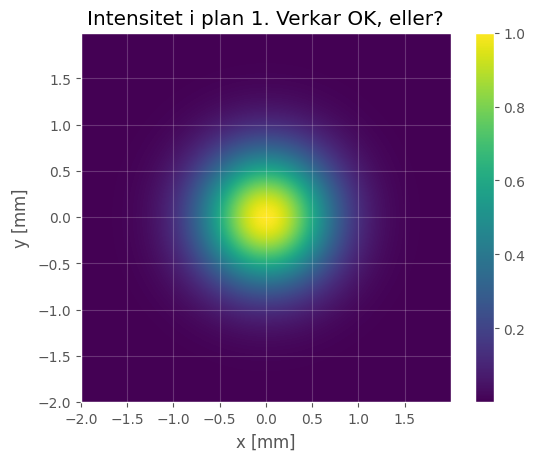

In [8]:
# Plotta intensitet i plan 1 
x_mm = x*1e3
y_mm = y*1e3

plt.figure()
image = plt.imshow(I1_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 1. Verkar OK, eller?')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

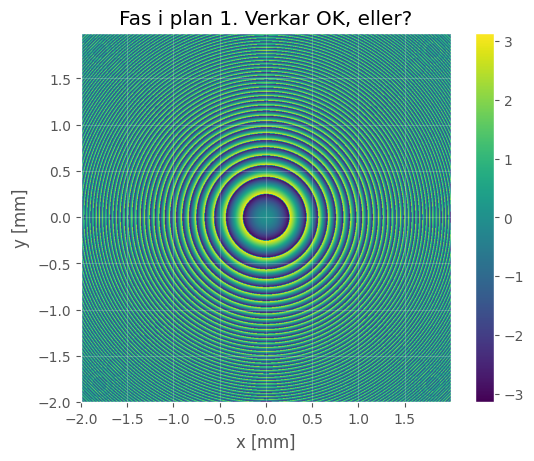

In [9]:
# Plotta fas i plan 1
plt.figure()
image = plt.imshow(np.angle(E1), extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Fas i plan 1. Verkar OK, eller?')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

In [10]:
# Propagera till plan 2
# GLÖM EJ ATT ÄNDRA VARIABLER MED '.x.'

E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intensitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

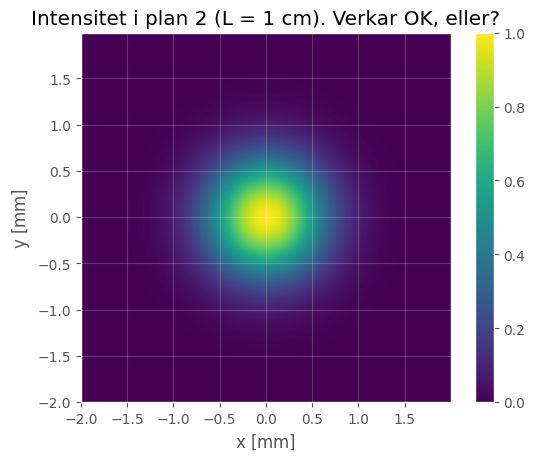

In [11]:
# Plotta intensitet i plan 2 
plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2 (L = 1 cm). Verkar OK, eller?')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

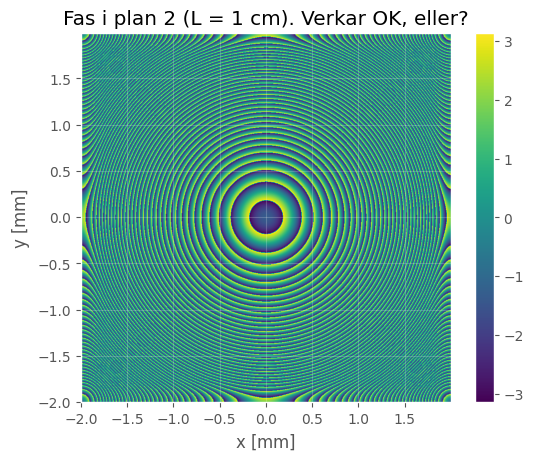

In [12]:
# Plotta fas i plan 2
plt.figure()
image = plt.imshow(np.angle(E2), extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Fas i plan 2 (L = 1 cm). Verkar OK, eller?')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

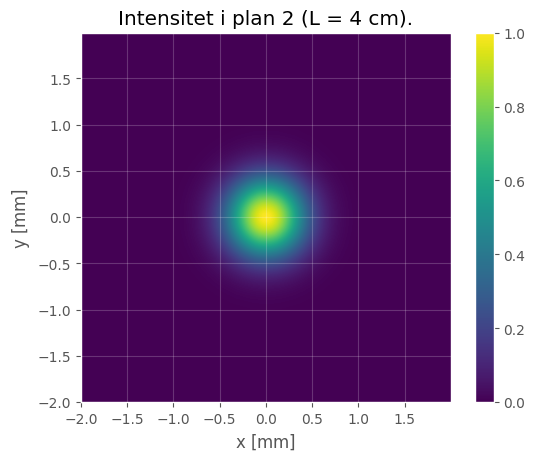

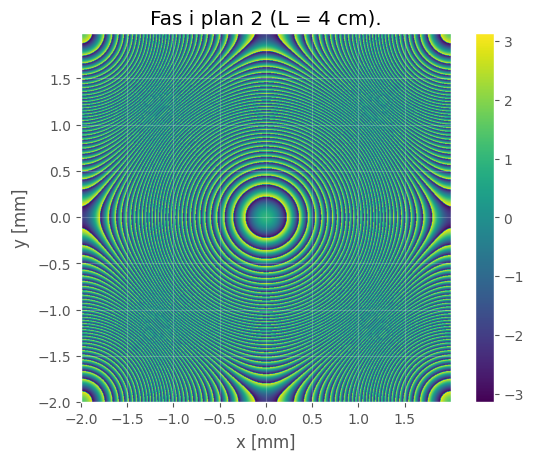

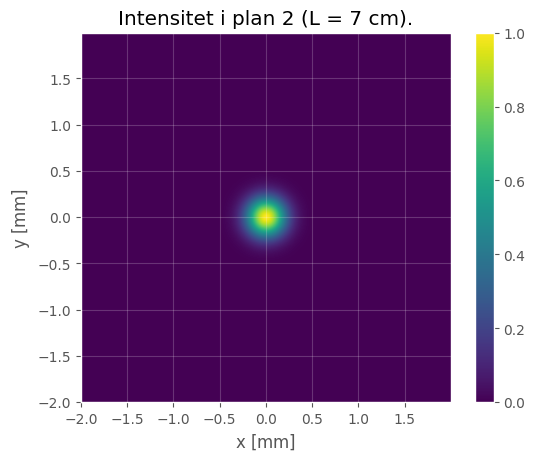

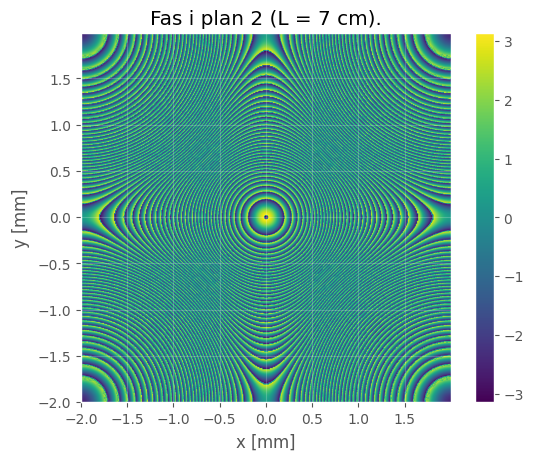

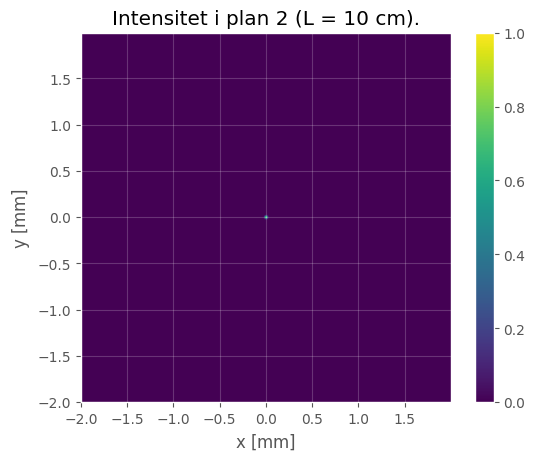

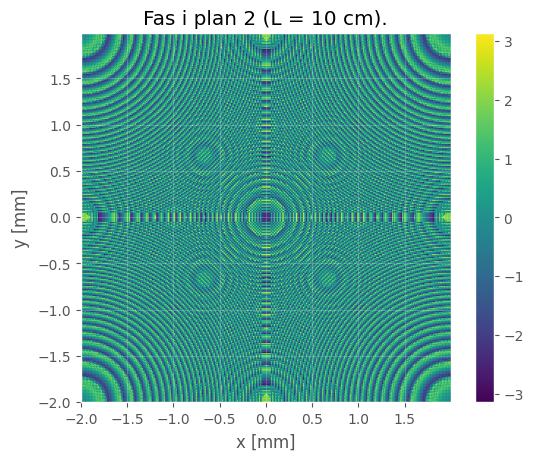

In [13]:
#L = 4 cm
L = 0.04
E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intensitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2 (L = 4 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

plt.figure()
image = plt.imshow(np.angle(E2), extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Fas i plan 2 (L = 4 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

#L = 7 cm
L = 0.07
E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intensitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2 (L = 7 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

plt.figure()
image = plt.imshow(np.angle(E2), extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Fas i plan 2 (L = 7 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

#L = 10 cm
L = 0.1
E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intensitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2 (L = 10 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

plt.figure()
image = plt.imshow(np.angle(E2), extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Fas i plan 2 (L = 10 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

In [14]:
#Man ser att intensiteten förblir gaussisk, men minskar i radie när avståndet mellan planen ökar. 

# Uppgift 3 - Gauss-strålens minsta spotsize

#### Kolla tumregeln om minsta spotsize, $D_{spot}=𝐶 \frac{𝜆}{D_{start}} 𝐿$, där $𝐶≈1$. Gör det för specialfallet gaussisk stråle ($𝜔_{in}=1$ mm) som fokuseras med hjälp av lins med $𝑓=10$ cm respektive $𝑓=1$ m. För definition av stråldiametern $𝐷$, använd i båda planen $𝐷=2𝜔$, där $𝜔$ är $1/e^2$-radien för intensiteten i respektive plan.

In [15]:
omega_in = 1e-3
lamb = 633e-9
f1 = 0.1
f2 = 1
D_start = 2*omega_in

#FALL 1: f = 10 cm
N               = 1024                # NxN är antalet samplade punkter (rekommenderad storlek N=1024)
sidlaengd_Plan1 = 4e-3                  # Det samplade områdets storlek (i x- eller y-led) i Plan 1 (rekommenderad storlek 4 mm)
a               = sidlaengd_Plan1/N     # Samplingsavstånd i Plan 1 (och Plan 2 eftersom vi använder PAS)
L               = f1                # Propagationssträcka (dvs avstånd mellan Plan 1 och 2)

lambda_noll = lamb                    # Vakuumvåglängd för rött ljus från en HeNe-laser
n_medium    = 1                         # Brytningsindex för medium mellan Plan 1 och 2
k           = (2*np.pi/(lambda_noll))*n_medium        # K-vektorns längd


x = np.arange(-(N/2)*a, (N/2)*a, a)     # Vektor med sampelpositioner i x-led
y = x                                   # och y-led

X, Y = np.meshgrid(x, y)                # Koordinatmatriser med x- och y-värdet i varje sampelposition
R    = np.sqrt(X**2 + Y**2)             # Avståndet till origo för varje sampelpunkt

f_lins = f1                        # Fokallängd på linsen före Plan 1
T_lins = np.exp(-1j*k*R**2/(2*f_lins))  # Transmissionsfunktion för en lins (linsen är TOK)

D_aperture = D_start                       # Diameter för apertur
T_aperture = R < (D_aperture/2)         # Transmissionsfunktion för en cirkulär apertur ("pupill")

omega1      = omega_in                      # 1/e2-radie (för intensiteten, dvs 1/e-radie för amplituden) för infallande Gaussiskt fält
E1_in_gauss = np.exp(-R**2/omega1**2)   # Infallande fält: Gaussiskt med plana vågfronter och normalinfall (dvs konstant fas, här=0)
E1_in_konst = np.ones(X.shape)          # Infallande fält: Konstant i hela plan 1. np.ones(X.shape) ger en matris fylld med ettor som har samma storlek som X


E1_gauss    = E1_in_gauss*T_lins         # Fältet i Plan 1 (precis efter linsen) för gaussisk stråle
E1_cirkular = E1_in_konst* T_lins * T_aperture    # Fältet i Plan 1 (precis efter linsen) för konstant fält som passerat genom cirkulär apertur


E1          = E1_gauss               # Välj fall!

E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intesitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

target = 1/np.e**2  # Målvärde för intensitet

# Platta ut matriserna till 1D-arrays
I2_flat = I2_norm.flatten()
R_flat  = R.flatten()

# Hitta index där intensiteten först sjunker under target
idx = np.where(I2_flat <= target)

r_targetlist = R_flat[idx]

D_spot_theoretical = (lamb/D_start) * f1
r_target = np.min(r_targetlist)
D_spot = 2*r_target

print("FALL 1 (f = 10 cm): \n")
print("Värde på D_spot enligt tumregel:", D_spot_theoretical)
print("1/e^2-radien är enligt PAS:", r_target)
print("D_spot är då enligt PAS:", D_spot)
print("De är så himla lika!")

C = (D_spot*D_start)/(lamb*f1)

print("Ett mer exakt värde på C är då:", C)
print("\n")

#FALL 1: f = 1 m

L = f2                # Propagationssträcka (dvs avstånd mellan Plan 1 och 2)

f_lins = f2                        # Fokallängd på linsen före Plan 1
T_lins = np.exp(-1j*k*R**2/(2*f_lins))  # Transmissionsfunktion för en lins (linsen är TOK)

E1_gauss    = E1_in_gauss*T_lins         # Fältet i Plan 1 (precis efter linsen) för gaussisk stråle
E1_cirkular = E1_in_konst* T_lins * T_aperture    # Fältet i Plan 1 (precis efter linsen) för konstant fält som passerat genom cirkulär apertur

E1          = E1_gauss               # Välj fall!

E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intesitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

# Platta ut matriserna till 1D-arrays
I2_flat = I2_norm.flatten()
R_flat  = R.flatten()

# Hitta index där intensiteten först sjunker under target
idx = np.where(I2_flat <= target)

r_targetlist = R_flat[idx]

D_spot_theoretical = (lamb/D_start) * f2
r_target = np.min(r_targetlist)
D_spot = 2*r_target

print("FALL 2 (f = 1 m): \n")
print("Värde på D_spot enligt tumregel:", D_spot_theoretical)
print("1/e^2-radien är enligt PAS:", r_target)
print("D_spot är då enligt PAS:", D_spot)
print("De är också så himla lika!")

C = (D_spot*D_start)/(lamb*f2)

print("Ett mer exakt värde på C är då:", C)

FALL 1 (f = 10 cm): 

Värde på D_spot enligt tumregel: 3.1650000000000004e-05
1/e^2-radien är enligt PAS: 2.103580002786692e-05
D_spot är då enligt PAS: 4.207160005573384e-05
De är så himla lika!
Ett mer exakt värde på C är då: 1.3292764630563614


FALL 2 (f = 1 m): 

Värde på D_spot enligt tumregel: 0.0003165
1/e^2-radien är enligt PAS: 0.00020282429665229756
D_spot är då enligt PAS: 0.0004056485933045951
De är också så himla lika!
Ett mer exakt värde på C är då: 1.281670121025577


#### **Vad blir det mer exakta värdet på $𝐶$ för den gaussiska strålen med den valda definitionen av $𝐷$?**

Enligt den valda definitionen av D ska C ligga någonstans runt 1,3.  

# Uppgift 4 - Cirkulära strålens minsta spotsize

#### Gör samma sak som i uppgift 3 fast nu ska fältet i Plan 1 ha konstant intensitet i ett cirkulärt tvärsnitt (diameter $D_{start}$), och $D_{spot}$ i Plan 2 definieras som ”innersta mörka ringens” diameter (vilket är en ganska generös definition av spotdiameter, så $𝐶$ bör bli klart större än 1).

FALL 1 (f = 10 cm): 

Värde på D_spot enligt tumregel: 3.1650000000000004e-05
D_spot är då enligt den nya definitionen (visuellt): 0,00006 m
De är så himla lika!
Ett mer exakt värde på C är då: 1.8957345971563981


FALL 2 (f = 1 m): 

Värde på D_spot enligt tumregel: 0.0003165
D_spot är då enligt den nya definitionen (visuellt): 0,0006 mm
De är också så himla lika!
Ett mer exakt värde på C är då: 1.895734597156398


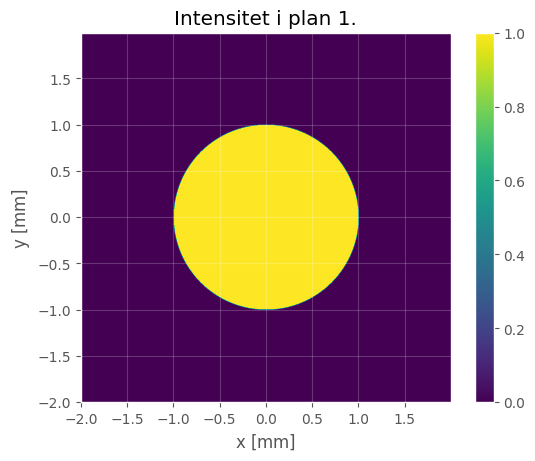

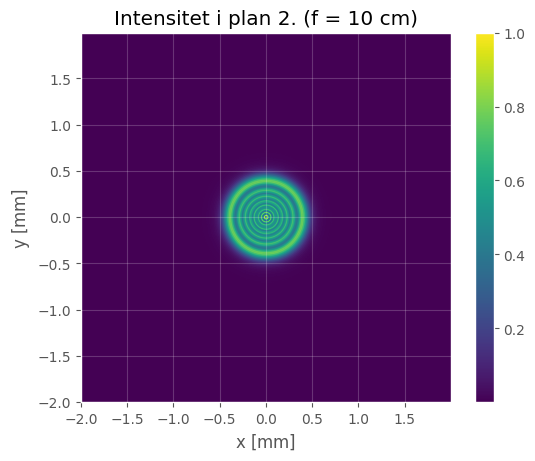

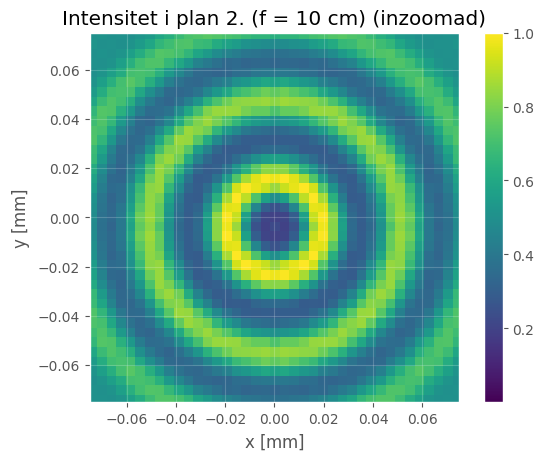

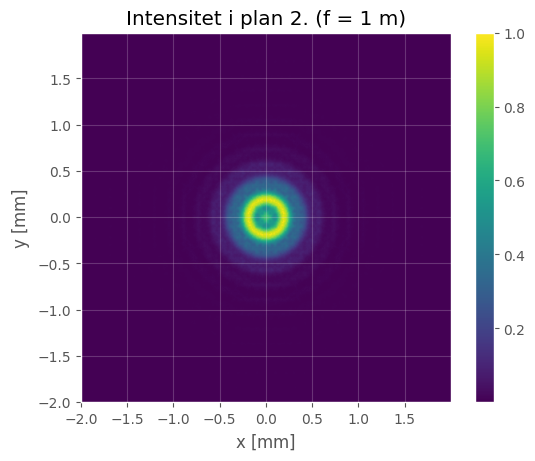

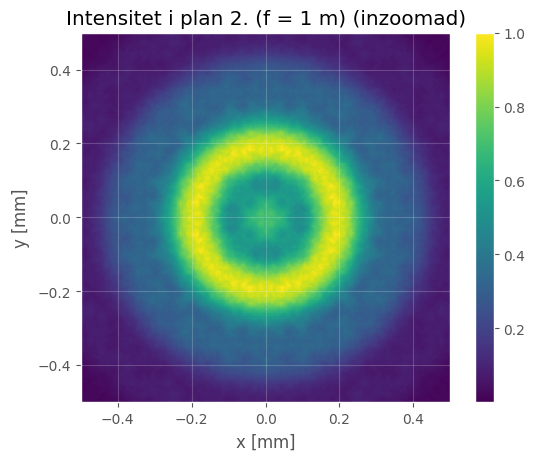

In [16]:
omega_in = 1e-3
lamb = 633e-9
f1 = 0.1
f2 = 1
D_start = 2*omega_in

#FALL 1: f = 10 cm
N               = 1024                # NxN är antalet samplade punkter (rekommenderad storlek N=1024)
sidlaengd_Plan1 = 4e-3                  # Det samplade områdets storlek (i x- eller y-led) i Plan 1 (rekommenderad storlek 4 mm)
a               = sidlaengd_Plan1/N     # Samplingsavstånd i Plan 1 (och Plan 2 eftersom vi använder PAS)
L               = f1/2                # Propagationssträcka (dvs avstånd mellan Plan 1 och 2)

lambda_noll = lamb                    # Vakuumvåglängd för rött ljus från en HeNe-laser
n_medium    = 1                         # Brytningsindex för medium mellan Plan 1 och 2
k           = (2*np.pi/(lambda_noll))*n_medium        # K-vektorns längd


x = np.arange(-(N/2)*a, (N/2)*a, a)     # Vektor med sampelpositioner i x-led
y = x                                   # och y-led

X, Y = np.meshgrid(x, y)                # Koordinatmatriser med x- och y-värdet i varje sampelposition
R    = np.sqrt(X**2 + Y**2)             # Avståndet till origo för varje sampelpunkt

f_lins = f1                        # Fokallängd på linsen före Plan 1
T_lins = np.exp(-1j*k*R**2/(2*f_lins))  # Transmissionsfunktion för en lins (linsen är TOK)

D_aperture = D_start                       # Diameter för apertur
T_aperture = R < (D_aperture/2)         # Transmissionsfunktion för en cirkulär apertur ("pupill")

omega1      = omega_in                      # 1/e2-radie (för intensiteten, dvs 1/e-radie för amplituden) för infallande Gaussiskt fält
E1_in_gauss = np.exp(-R**2/omega1**2)   # Infallande fält: Gaussiskt med plana vågfronter och normalinfall (dvs konstant fas, här=0)
E1_in_konst = np.ones(X.shape)          # Infallande fält: Konstant i hela plan 1. np.ones(X.shape) ger en matris fylld med ettor som har samma storlek som X


E1_gauss    = E1_in_gauss*T_lins         # Fältet i Plan 1 (precis efter linsen) för gaussisk stråle
E1_cirkular = E1_in_konst* T_lins * T_aperture    # Fältet i Plan 1 (precis efter linsen) för konstant fält som passerat genom cirkulär apertur


E1          = E1_cirkular               # Välj fall!

E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intesitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

D_spot_theoretical = (lamb/D_start) * f1

print("FALL 1 (f = 10 cm): \n")
print("Värde på D_spot enligt tumregel:", D_spot_theoretical)
print("D_spot är då enligt den nya definitionen (visuellt): 0,00006 m")
D_spot = 0.00006
print("De är så himla lika!")

C = (D_spot*D_start)/(lamb*f1)

print("Ett mer exakt värde på C är då:", C)
print("\n")

#Plotta intensitet i plan 1 och 2 för f = 10 cm
I1      = np.abs(E1)**2     # Intensiteten är prop mot kvadraten på fältets amplitud (normalt struntar man i proportionalitetskonstanten)
I1_norm = I1/np.max(I1)     # Då vi inte är intresserade av det absoluta värdet av intensiteten så kan det vara trevligt att noramlizera intensiten innan vi plottar

x_mm = x*1e3
y_mm = y*1e3

plt.figure()
image = plt.imshow(I1_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 1.')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha = 0.2)

x_mm = x*1e3
y_mm = y*1e3

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2. (f = 10 cm)')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha = 0.2)

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2. (f = 10 cm) (inzoomad)')
plt.xlim((-0.075,0.075))
plt.ylim((-0.075,0.075))
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha = 0.2)

#FALL 1: f = 1 m

L = f2/2             # Propagationssträcka (dvs avstånd mellan Plan 1 och 2)

f_lins = f2                        # Fokallängd på linsen före Plan 1
T_lins = np.exp(-1j*k*R**2/(2*f_lins))  # Transmissionsfunktion för en lins (linsen är TOK)

E1_gauss    = E1_in_gauss*T_lins         # Fältet i Plan 1 (precis efter linsen) för gaussisk stråle
E1_cirkular = E1_in_konst* T_lins * T_aperture    # Fältet i Plan 1 (precis efter linsen) för konstant fält som passerat genom cirkulär apertur

E1          = E1_cirkular               # Välj fall!

E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intesitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

D_spot_theoretical = (lamb/D_start) * f2

print("FALL 2 (f = 1 m): \n")
print("Värde på D_spot enligt tumregel:", D_spot_theoretical)
print("D_spot är då enligt den nya definitionen (visuellt): 0,0006 mm")
D_spot = 0.0006
print("De är också så himla lika!")

C = (D_spot*D_start)/(lamb*f2)

print("Ett mer exakt värde på C är då:", C)


#Plotta intensitet i plan 2 för f = 1 m
x_mm = x*1e3
y_mm = y*1e3

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2. (f = 1 m)')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha = 0.2)

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2. (f = 1 m) (inzoomad)')
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha = 0.2)

#### **Vad blir det mer exakta värdet på $𝐶$ för den cirkulära strålen och de valda definitionerna av $𝐷$?**

Cirka 1,9. Dock är detta inte helt säkert då vi endast använder okulär inspektion för att bestämma radierna. 

#### **Kan du i något av fallen $𝑓= 10$ cm eller $𝑓=1$ m se svaga tecken på numeriska fel i simuleringen av intensitetsfördelningen i fjärrfältet?**

Försöket med 1 meter blev lite suddigare tycker vi. Vi tror detta kan bero på att ljuset sprider sig, och att det sker mer diffraktion. Vi har lika många samplingspunkter i båda situationerna men ett större "område" i fallet med 1 meter. 

# Uppgift 5 - Möt en annan medlem i gauss-strålens storfamilj!

#### Det finns en hel lycklig familj med fält som delar gausstrålens egenskap att inte ändra form (förutom storlek) när de propagerar: så kallade *hermite-gaussiska strålar*. En av dessa strålar fås helt enkelt genom att multiplicera den (vanliga) gaussiska strålen i startplanet med $𝑥$. Kolla att detta infält också håller formen vid propagation ända till fjärrfältet! <span style="background-color:yellow">Behöver ej redovisas!</span>

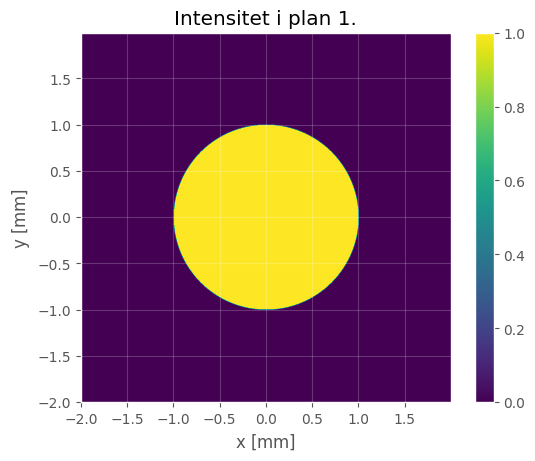

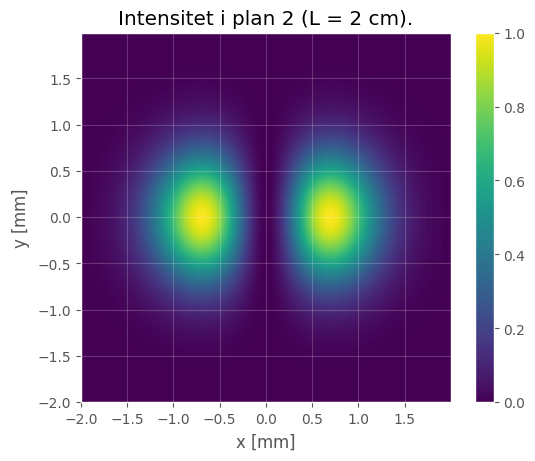

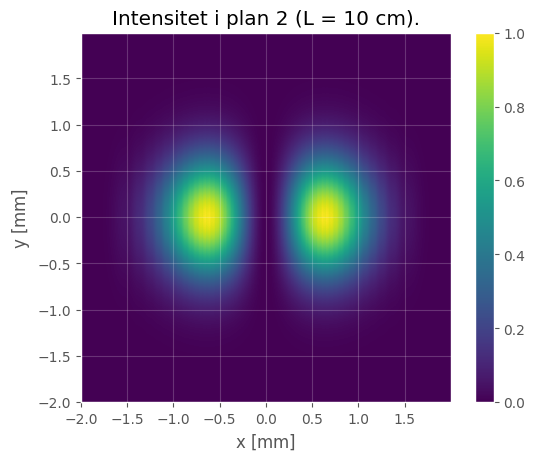

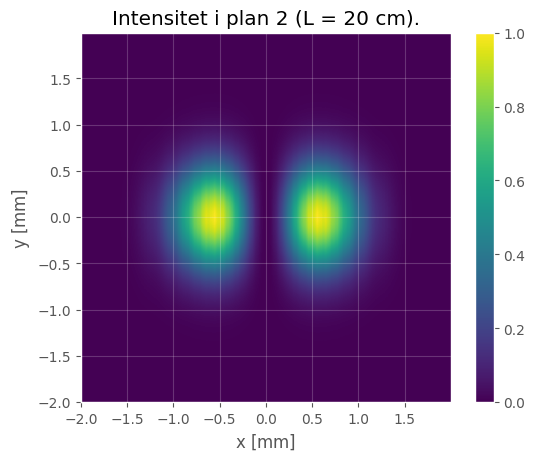

In [17]:
I1      = np.abs(E1)**2     # Intensiteten är prop mot kvadraten på fältets amplitud (normalt struntar man i proportionalitetskonstanten)
I1_norm = I1/np.max(I1)     # Då vi inte är intresserade av det absoluta värdet av intensiteten så kan det vara trevligt att noramlizera intensiten innan vi plottar

E1 = x*E1_gauss

x_mm = x*1e3
y_mm = y*1e3

plt.figure()
image = plt.imshow(I1_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 1.')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

#L = 2 cm
L = 0.02
E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intensitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2 (L = 2 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

#L = 10 cm
L = 0.1
E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intensitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2 (L = 10 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

#L = 20 cm
L = 0.2
E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intensitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta

plt.figure()
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2 (L = 20 cm).')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')
plt.grid(alpha=0.2)

# Uppgift 6 - Dubbla budskap

In [18]:
# Ladda in DOE såhär!
DOE = np.flip(io.loadmat('T_DOE_gen2.mat'))["T_DOE_gen2"]

(0.75, -0.5)

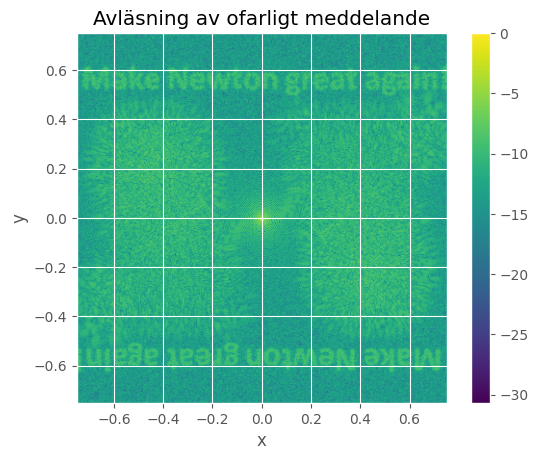

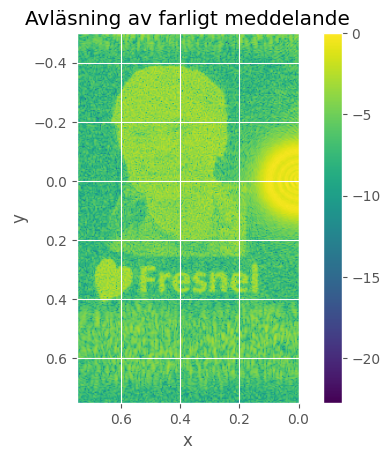

In [23]:
# Skapa det elektriska fältet som träffar ögat och propagera med pas
L = 0.02
f_vise = 0.1534                        
T_vise = np.exp(-1j*k*R**2/(2*f_vise))  # Transmissionsfunktion för en lins (linsen är TOK)
f_öga = 0.02
T_öga = np.exp(-1j*k*R**2/(2*f_öga))  # Transmissionsfunktion för en lins (linsen är TOK)


E1_farlig = E1_in_konst * T_vise * DOE * T_öga
E2_farlig = PAS(E1_farlig, L, N, a, lambda_noll, n_medium)  

E1_ofarlig = E1_in_konst * DOE * T_öga
E2_ofarlig = PAS(E1_ofarlig, L, N, a, lambda_noll, n_medium)  

# Fältet som har propagerats genom DOE och 'de vises lins' är smidigt att
# plotta i logaritmisk skala för att bilden ska vara tydlig.
# Alltså plotta fältet i plan 2 så här!

#OFARLIGT MEDDELANDE
I2      = np.abs(E2_ofarlig)**2    
I2_norm = np.log(I2/np.max(I2))  # Log av den normaliserade intensiteten i plan 2

x_mm = x*1e3
y_mm = y*1e3

plt.figure()
plt.title("Avläsning av ofarligt meddelande")
plt.xlabel("x")
plt.ylabel("y")
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)

#FARLIGT MEDDELANDE
I2      = np.abs(E2_farlig)**2    
I2_norm = np.log(I2/np.max(I2))  # Log av den normaliserade intensiteten i plan 2

x_mm = x*1e3
y_mm = y*1e3

plt.figure()
plt.title("Avläsning av farligt meddelande")
plt.xlabel("x")
plt.ylabel("y")
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)
plt.xlim(0.75,0)
plt.ylim(0.75,-0.5)


#### **Vilket är det ofarliga meddelandet i den bifogade DOE-koden av generation 2-typ?** 

Make Newton great again!

#### **Och vilken styrka krävs på ”de vises lins” för att läsa det farliga budskapet i samma kod? Testa dig fram med olika värden på styrkan hos de vises lins tills du kan urskilja budskapet.**

Vi provade massa värden på f_vise, med start vid 0,02. Enligt okulär inspektion uppnåddes tydligast resultat vid typ 0,15.